In [185]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

In [186]:
file_path = '../Features/Rabbit_B_SHAP_SVM.xlsx'
df = pd.read_excel(file_path)
df.head()

,PEOE_VSA11,EState_VSA2,VSA_EState6,SMR_VSA6,SMR_VSA10,PEOE_VSA9,fr_NH1,fr_amide,Irritation
0,0.000000,0.000000,0.000000,0.216018,0.000000,0.000000,0.000000,0.000000,1
1,0.000000,0.256312,0.000000,0.225150,0.208314,0.230156,0.000000,0.000000,1
2,0.680370,0.456627,0.403000,0.217041,0.292175,0.361580,0.408248,0.408248,0
3,0.392847,0.508912,0.282099,0.373221,0.290325,0.385121,0.408248,0.408248,0
4,0.000000,0.448460,0.226058,0.285657,0.583650,0.205850,0.408248,0.912871,0


In [187]:
df.shape

(857, 9)

In [188]:
print(df.columns.to_list())

['PEOE_VSA11', 'EState_VSA2', 'VSA_EState6', 'SMR_VSA6', 'SMR_VSA10', 'PEOE_VSA9', 'fr_NH1', 'fr_amide', 'Irritation']


In [189]:
# Define features (X) and target variable (y)
X = df.drop(columns=['Irritation'])  
y = df['Irritation']

In [190]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=5)


# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 685 samples
Test set: 172 samples


In [191]:
def objective(trial):

    param = {
        "C": trial.suggest_float("C", 0.1, 10),
        "kernel": trial.suggest_categorical("kernel", ["rbf"]),
        "gamma": "scale",
        "class_weight": "balanced",
    }
    

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_cv, X_valid_cv = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = SVC(**param, probability=True) 
        model.fit(X_train_cv, y_train_cv)
 
        valid_acc = f1_score(y_valid_cv, model.predict(X_valid_cv))
        valid_scores.append(valid_acc)

    return np.mean(valid_scores)

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best trial:", study.best_trial.params)

[I 2025-05-05 19:00:08,939] A new study created in memory with name: no-name-8e692260-5ba5-435a-9deb-36f376e3af24
[I 2025-05-05 19:00:09,145] Trial 0 finished with value: 0.7379525270097053 and parameters: {'C': 0.14005391684837293, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7379525270097053.
[I 2025-05-05 19:00:09,251] Trial 1 finished with value: 0.7432436284509725 and parameters: {'C': 5.098980432126549, 'kernel': 'rbf'}. Best is trial 1 with value: 0.7432436284509725.
[I 2025-05-05 19:00:09,361] Trial 2 finished with value: 0.7429806553472198 and parameters: {'C': 7.000315697899596, 'kernel': 'rbf'}. Best is trial 1 with value: 0.7432436284509725.
[I 2025-05-05 19:00:09,473] Trial 3 finished with value: 0.7417936398433438 and parameters: {'C': 6.859521091391718, 'kernel': 'rbf'}. Best is trial 1 with value: 0.7432436284509725.
[I 2025-05-05 19:00:09,591] Trial 4 finished with value: 0.7489698936326666 and parameters: {'C': 3.2161418295374307, 'kernel': 'rbf'}. Best is trial 4 

Best trial: {'C': 1.5395308888821266, 'kernel': 'rbf'}


In [192]:
from sklearn.metrics import precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

best_params = study.best_trial.params

# Initialize the SVM model with best parameters
final_model = SVC(**best_params, probability=True)

# Fit the model
final_model.fit(X_train, y_train)

# Accuracy
train_accuracy = final_model.score(X_train, y_train)
test_accuracy = final_model.score(X_test, y_test)

# Predictions
y_pred = final_model.predict(X_test)

# Metrics
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Train Accuracy: 0.8131386861313868
Test Accuracy: 0.7906976744186046
Precision: 0.7432432432432432
Recall: 0.7638888888888888
F1 Score: 0.7534246575342466


In [193]:
test_accuracies = []
train_accuracies = []

for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    
    best_params = study.best_trial.params

    # Initialize the KNN model with best parameters
    final_model = SVC(**best_params, probability=True)

    # Fit the model on the training data
    final_model.fit(X_train, y_train)


    test_accuracy = final_model.score(X_test, y_test)
    train_accuracy = final_model.score(X_train, y_train)
    #print("Train Accuracy:", train_accuracy)
    #print("Test Accuracy:", test_accuracy)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

print(np.mean(train_accuracies), np.mean(test_accuracies))

0.8093430656934307 0.7982558139534884


Final Model Accuracy on Test: 0.7965116279069767


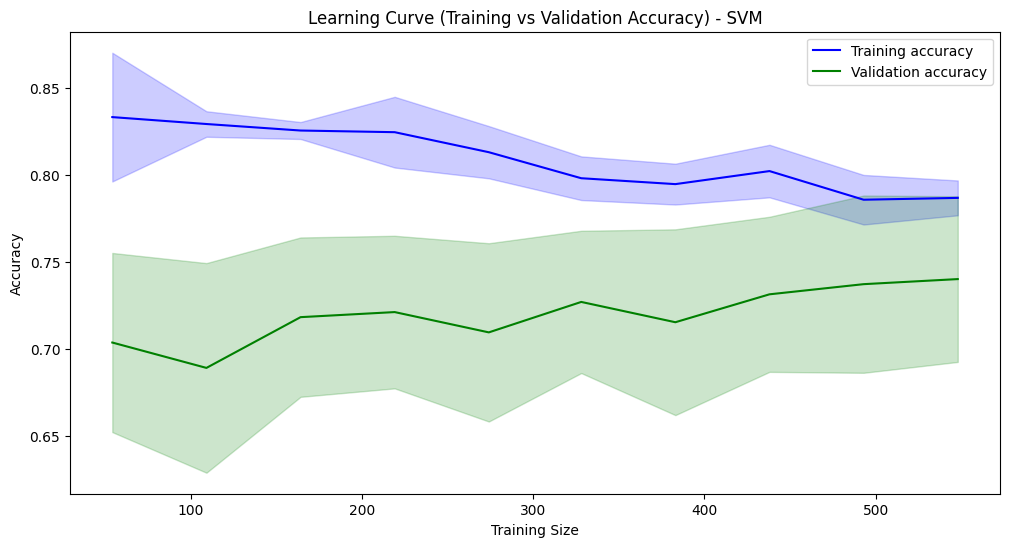

Train Accuracy: 0.7897810218978102
Test Accuracy: 0.7965116279069767


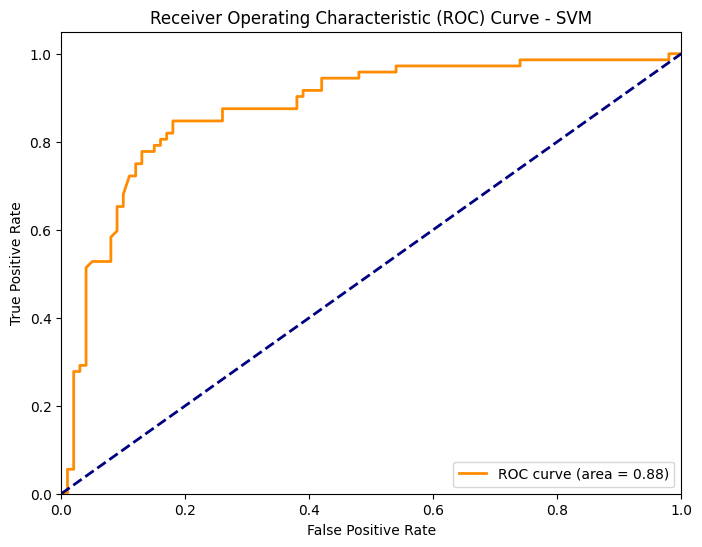

In [194]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt

# Get best hyperparameters from study
best_params = study.best_trial.params
best_params =  {'C': 0.6279728945930269, 'kernel': 'poly'}

# Initialize the KNN model with best parameters
final_model = SVC(**best_params, probability=True)

# Fit the model on the training data
final_model.fit(X_train, y_train)

# Evaluate final model on test data
y_pred_final = final_model.predict(X_test)
print("Final Model Accuracy on Test:", accuracy_score(y_test, y_pred_final))

# Learning Curves
train_sizes, train_scores, validation_scores = learning_curve(
    final_model, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training accuracy', color='blue')
plt.plot(train_sizes, validation_mean, label='Validation accuracy', color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.2)
plt.title('Learning Curve (Training vs Validation Accuracy) - SVM')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate accuracy on test data
test_accuracy = final_model.score(X_test, y_test)
train_accuracy = final_model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# ROC Curve
y_prob = final_model.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.show()


In [195]:
sample_X = shap.sample(X_train, 200) 

background_summary = shap.sample(X_train, 25)
explainer = shap.KernelExplainer(final_model.predict_proba, background_summary)

shap_values = explainer.shap_values(sample_X)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
shap.summary_plot(shap_values[:,:,1], X_train)

In [ ]:
import joblib

joblib.dump(final_model, 'svm_model.pkl')

print("Model saved successfully!")
